# Steric correction

*Johannes Hörmann, 2020*

Impose steric radii on a sample point distribution by minizing pseudo-potential.
Pseudo-ptential follows formalism described in

*L. Martinez, R. Andrade, E. G. Birgin, and J. M. Martínez, “PACKMOL: A package for building initial configurations for molecular dynamics simulations,” J. Comput. Chem., vol. 30, no. 13, pp. 2157–2164, 2009, doi: 10/chm6f7.*


In [1]:
# for dynamic module reload during testing, code modifications take immediate effect
%load_ext autoreload
%autoreload 2

In [2]:
# stretching notebook width across whole window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# basics & utilities
import itertools                # dealing with combinations and permutations
import logging                  # easy and neat handlin of log outpu
import matplotlib.pyplot as plt # plotting
import numpy as np              # basic numerics, in particular lin. alg.
import pandas as pd             # display stats neatly
import scipy.constants as sc    # fundamental constants
import scipy.spatial.distance   # quick methods for computing pairwise distances
import time                     # timing performance
import timeit                   # same purpose

In [4]:
# electrochemistry basics
from matscipy.electrochemistry import debye, ionic_strength

In [5]:
# Poisson-Bolzmann distribution
from matscipy.electrochemistry.poisson_boltzmann_distribution import gamma, potential, concentration, charge_density

In [6]:
# sampling
from scipy import interpolate
from matscipy.electrochemistry import continuous2discrete
from matscipy.electrochemistry import get_histogram
from matscipy.electrochemistry.utility import plot_dist

In [7]:
# steric correction

# target functions
from matscipy.electrochemistry.steric_correction import scipy_distance_based_target_function
from matscipy.electrochemistry.steric_correction import numpy_only_target_function
from matscipy.electrochemistry.steric_correction import brute_force_target_function

# closest pair functions
from matscipy.electrochemistry.steric_correction import brute_force_closest_pair
from matscipy.electrochemistry.steric_correction import planar_closest_pair
from matscipy.electrochemistry.steric_correction import scipy_distance_based_closest_pair

from matscipy.electrochemistry.steric_correction import apply_steric_correction

In [8]:
# 3rd party file output
import ase
import ase.io

In [9]:
# matscipy.electrochemistry makes extensive use of Python's logging module

# configure logging: verbosity level and format as desired
standard_loglevel   = logging.INFO
# standard_logformat  = ''.join(("%(asctime)s",
#  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))
standard_logformat  = "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"

# reset logger if previously loaded
logging.shutdown()
logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

# in Jupyter notebooks, explicitly modifying the root logger necessary
logger = logging.getLogger()
logger.setLevel(standard_loglevel)

# remove all handlers
for h in logger.handlers: logger.removeHandler(h)

# create and append custom handles
ch = logging.StreamHandler()
formatter = logging.Formatter(standard_logformat)
ch.setFormatter(formatter)
ch.setLevel(standard_loglevel)
logger.addHandler(ch)

In [10]:
# Test 1
logging.info("Root logger")

[ <ipython-input-10-adec08aea02d>:2 - <module>() ]: Root logger


In [11]:
# Test 2
logger.info("Root Logger")

[ <ipython-input-11-4335e316391c>:2 - <module>() ]: Root Logger


In [12]:
# Debug Test
logging.debug("Root logger")

## Step 1: Solve for continuous concentration distributions
See other sample case notebboks for details


In [13]:
# measures of box
xsize = ysize = 5e-9 # nm, SI units
zsize = 20e-9         # nm, SI units

# get continuum distribution, z direction
x = np.linspace(0, zsize, 2000)
c = [1,1]
z = [1,-1]
u = 0.05 

phi = potential(x, c, z, u)
C   = concentration(x, c, z, u)
rho = charge_density(x, c, z, u)

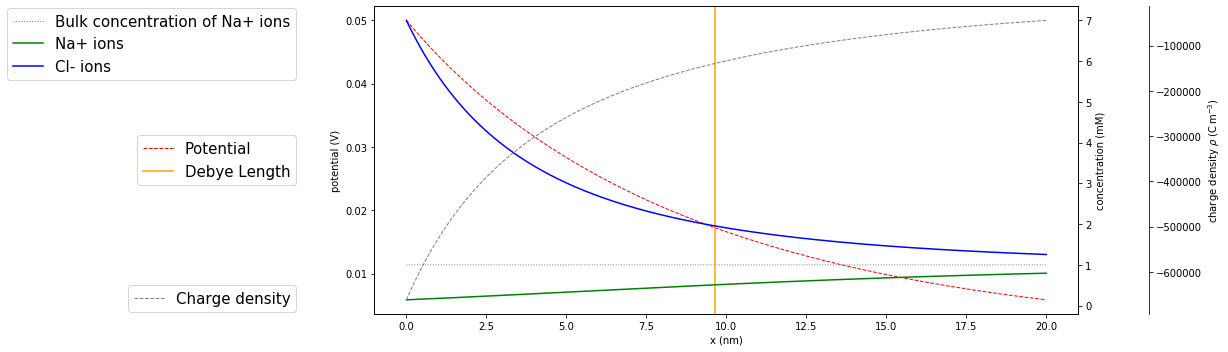

In [14]:
# potential and concentration distributions analytic solution 
# based on Poisson-Boltzmann equation for 0.1 mM NaCl aqueous solution 
# at interface 
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        

deb = debye(c, z) 

fig, ax1 = plt.subplots(figsize=[18,5])
ax1.set_xlabel('x (nm)')
ax1.plot(x/sc.nano, phi, marker='', color='red', label='Potential', linewidth=1, linestyle='--')
ax1.set_ylabel('potential (V)')
ax1.axvline(x=deb/sc.nano, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='Bulk concentration of Na+ ions', color='grey', linewidth=1, linestyle=':')
ax2.plot(x/sc.nano, C[0], marker='', color='green', label='Na+ ions')
ax2.plot(x/sc.nano, C[1], marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('concentration (mM)')

ax3 = ax1.twinx()
# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density', color='grey', linewidth=1, linestyle='--')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')

#fig.legend(loc='center')
ax2.legend(loc='upper right', bbox_to_anchor=(-0.1, 1.02),fontsize=15)
ax1.legend(loc='center right', bbox_to_anchor=(-0.1,0.5), fontsize=15)
ax3.legend(loc='lower right', bbox_to_anchor=(-0.1, -0.02), fontsize=15)
fig.tight_layout()
plt.show()

## Step 2: Sample from distribution

In [15]:
# create distribution functions
distributions = [interpolate.interp1d(x,c) for c in C]

# sample discrete coordinate set
box3 = np.array([xsize, ysize, zsize])
sample_size = 200

[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y direction.
[ continuous2discrete.py:257 - generate_structure() ]: Using distribution <scipy.interpolate.interpolate.interp1d object at 0x7f067dcec908> along z direction.
[ continuous2discrete.py:271 - generate_structure() ]: Using [nan nan nan] grid as sampling support.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7f06acc44048> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7f06acc44048> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <scipy.interpolate.interpolate.interp1d object at 0x7f067dcec908> by 1.0069226132436612e-08.
[ continuous2discrete.py:298 - generate_structure() ]: Drew (200, 3) samples from distributions.
[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y dir

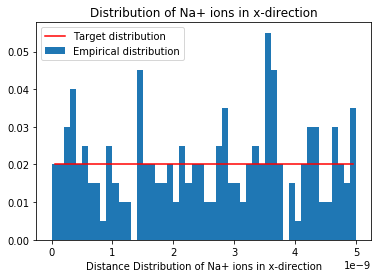

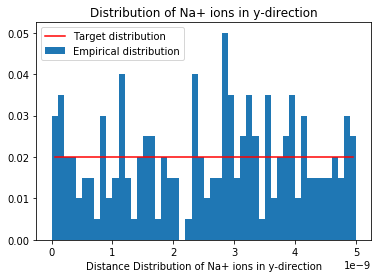

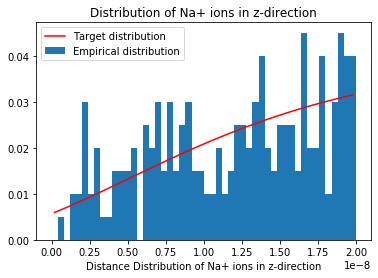

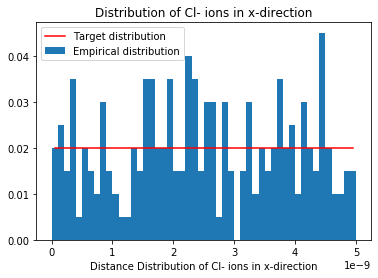

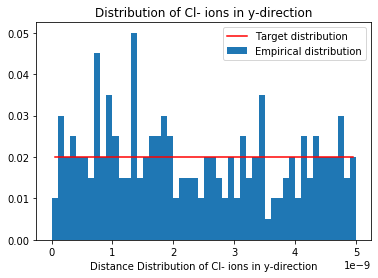

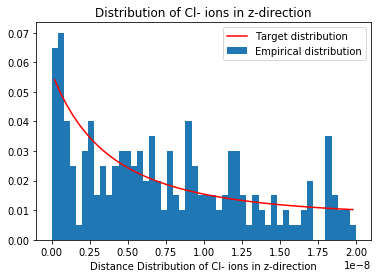

In [16]:
samples = [ continuous2discrete(distribution=d, box=box3, count=sample_size) for d in distributions ]
species = ['Na+','Cl-']
for ion,sample,d in zip(species,samples,distributions):
    histx, histy, histz = get_histogram(sample, box=box3, n_bins=51)
    plot_dist(histx, 'Distribution of {:s} ions in x-direction'.format(ion), 
              reference_distribution=lambda x: np.ones(x.shape)*1/box3[0])
    plot_dist(histy, 'Distribution of {:s} ions in y-direction'.format(ion), 
              reference_distribution=lambda x: np.ones(x.shape)*1/box3[1])
    plot_dist(histz, 'Distribution of {:s} ions in z-direction'.format(ion), 
              reference_distribution=d)

## Step 3: Enforce steric radii

Initial state of system:

In [17]:
# need all coordinates in one N x 3 array
xstacked = np.vstack(samples)

box6 = np.array([[0.,0.,0],box3]) # needs lower corner

n = xstacked.shape[0]
dim = xstacked.shape[1]

# benchmakr methods
mindsq, (p1,p2) = scipy_distance_based_closest_pair(xstacked)
pmin = np.min(xstacked,axis=0)
pmax = np.max(xstacked,axis=0)
mind = np.sqrt(mindsq)
logger.info("Minimum pair-wise distance in sample: {}".format(mind))
logger.info("First sample point in pair:    ({:8.4e},{:8.4e},{:8.4e})".format(*p1))
logger.info("Second sample point in pair    ({:8.4e},{:8.4e},{:8.4e})".format(*p2))
logger.info("Box lower boundary:            ({:8.4e},{:8.4e},{:8.4e})".format(*box6[0]))
logger.info("Minimum coordinates in sample: ({:8.4e},{:8.4e},{:8.4e})".format(*pmin))
logger.info("Maximum coordinates in sample: ({:8.4e},{:8.4e},{:8.4e})".format(*pmax))
logger.info("Box upper boundary:            ({:8.4e},{:8.4e},{:8.4e})".format(*box6[1]))

[ <ipython-input-17-ec5679b8f5f1>:14 - <module>() ]: Minimum pair-wise distance in sample: 1.352188695855715e-10
[ <ipython-input-17-ec5679b8f5f1>:15 - <module>() ]: First sample point in pair:    (4.4566e-09,3.7113e-09,1.3501e-08)
[ <ipython-input-17-ec5679b8f5f1>:16 - <module>() ]: Second sample point in pair    (4.3269e-09,3.6958e-09,1.3537e-08)
[ <ipython-input-17-ec5679b8f5f1>:17 - <module>() ]: Box lower boundary:            (0.0000e+00,0.0000e+00,0.0000e+00)
[ <ipython-input-17-ec5679b8f5f1>:18 - <module>() ]: Minimum coordinates in sample: (2.3292e-12,6.1885e-13,2.2696e-11)
[ <ipython-input-17-ec5679b8f5f1>:19 - <module>() ]: Maximum coordinates in sample: (4.9992e-09,4.9942e-09,1.9953e-08)
[ <ipython-input-17-ec5679b8f5f1>:20 - <module>() ]: Box upper boundary:            (5.0000e-09,5.0000e-09,2.0000e-08)


In [19]:
# apply penalty for steric overlap

# stats: method, x, res, dt, mind, p1, p2 , pmin, pmax
stats = [('initial',xstacked,None,0,mind,p1,p2,pmin,pmax)]

r = 2e-10 # 4 Angstrom steric radius
logger.info("Steric radius: {:8.4e}".format(r))

# see https://scipy-lectures.org/advanced/mathematical_optimization/index.html
methods = [
    #'Nelder-Mead', # not suitable
    'Powell',
    'CG',
    'BFGS',
    #'Newton-CG', # needs explicit Jacobian
    'L-BFGS-B' 
]
        
for m in methods:
    try:
        logger.info("### {} ###".format(m))
        t0 = time.perf_counter()
        x1, res = apply_steric_correction(xstacked,box=box6,r=r,method=m)
        t1 = time.perf_counter()
        dt = t1 - t0
        logger.info("{} s runtime".format(dt))
        
        mindsq, (p1,p2) = scipy_distance_based_closest_pair(x1)
        mind = np.sqrt(mindsq)
        pmin = np.min(x1,axis=0)
        pmax = np.max(x1,axis=0)

        stats.append([m,x1,res,dt,mind,p1,p2,pmin,pmax])
        
        logger.info("{:s} finished with".format(m))
        logger.info("    status = {}, success = {}, #it = {}".format(
            res.status, res.success, res.nit))
        logger.info("    message = '{}'".format(res.message))
        logger.info("Minimum pair-wise distance in final configuration: {:8.4e}".format(mind))
        logger.info("First sample point in pair:    ({:8.4e},{:8.4e},{:8.4e})".format(*p1))
        logger.info("Second sample point in pair    ({:8.4e},{:8.4e},{:8.4e})".format(*p2))
        logger.info("Box lower boundary:            ({:8.4e},{:8.4e},{:8.4e})".format(*box6[0]))
        logger.info("Minimum coordinates in sample: ({:8.4e},{:8.4e},{:8.4e})".format(*pmin))
        logger.info("Maximum coordinates in sample: ({:8.4e},{:8.4e},{:8.4e})".format(*pmax))
        logger.info("Box upper boundary:            ({:8.4e},{:8.4e},{:8.4e})".format(*box6[1]))
    except:
        logger.warning("{} failed.".format(m))
        continue
        
stats_df = pd.DataFrame( [ { 
    'method':  s[0], 
    'runtime': s[3],
    'mind':    s[4],
    **{'p1{:d}'.format(i): c for i,c in enumerate(s[5]) },
    **{'p2{:d}'.format(i): c for i,c in enumerate(s[6]) }, 
    **{'pmin{:d}'.format(i): c for i,c in enumerate(s[7]) },
    **{'pmax{:d}'.format(i): c for i,c in enumerate(s[8]) }
} for s in stats] )

print(stats_df.to_string(float_format='%8.6g'))

[ <ipython-input-19-3d6fcc74b808>:7 - <module>() ]: Steric radius: 2.0000e-10
[ <ipython-input-19-3d6fcc74b808>:21 - <module>() ]: ### Powell ###
[ steric_correction.py:705 - apply_steric_correction() ]: Normalizing coordinates by reference length
[ steric_correction.py:707 - apply_steric_correction() ]:     L = V^(1/dim) = (5e-25)^(1/3) = 7.9e-09.
[ steric_correction.py:715 - apply_steric_correction() ]: Normalized bounding box: 
[ steric_correction.py:716 - apply_steric_correction() ]:     [0. 0. 0.].
[ steric_correction.py:717 - apply_steric_correction() ]:     [0.62996052 0.62996052 2.5198421 ].
[ steric_correction.py:726 - apply_steric_correction() ]: Initial constraint penalty: 1.58368e-02.
[ steric_correction.py:727 - apply_steric_correction() ]: Initial total penalty:      1.58786e-02.
[ steric_correction.py:739 - minimizer_callback() ]:    #callback    objective   min. dist. timing, step timing, tot.
[ steric_correction.py:753 - minimizer_callback() ]:            0  1.58786e-0

[ steric_correction.py:727 - apply_steric_correction() ]: Initial total penalty:      1.58786e-02.
[ steric_correction.py:739 - minimizer_callback() ]:    #callback    objective   min. dist. timing, step timing, tot.
[ steric_correction.py:753 - minimizer_callback() ]:            0  1.58786e-02  1.70365e-02  4.69586e-03  4.69586e-03
[ steric_correction.py:753 - minimizer_callback() ]:            1  5.00035e-05  1.73055e-02  5.38205e+00  5.38675e+00
[ steric_correction.py:753 - minimizer_callback() ]:            2  2.47545e-05  2.30895e-02  5.39853e+00  1.07853e+01
[ steric_correction.py:753 - minimizer_callback() ]:            3  1.26399e-05  2.76772e-02  3.41567e+00  1.42009e+01
[ steric_correction.py:753 - minimizer_callback() ]:            4  6.74529e-06  3.13555e-02  1.77551e+00  1.59765e+01
[ steric_correction.py:753 - minimizer_callback() ]:            5  5.92748e-06  3.58412e-02  1.87327e+00  1.78497e+01
[ steric_correction.py:753 - minimizer_callback() ]:            6  4.47451e

     method  runtime        mind         p10         p11         p12         p20         p21         p22       pmin0       pmin1       pmin2       pmax0       pmax1       pmax2
0   initial        0 1.35219e-10 4.45657e-09 3.71127e-09 1.35014e-08 4.32692e-09 3.69577e-09 1.35366e-08 2.32922e-12 6.18851e-13 2.26956e-11 4.99919e-09  4.9942e-09 1.99532e-08
1    Powell  286.406 4.02481e-10 2.77746e-09 4.53219e-09 1.64386e-08 2.98895e-09 4.58847e-09 1.61008e-08 2.11893e-10  2.0707e-10 2.88194e-10  4.7969e-09 4.78145e-09 1.97945e-08
2        CG  79.9331 3.98923e-10 4.50861e-09 1.01956e-09 4.85291e-10 4.53313e-09 6.21427e-10 4.90507e-10 2.01612e-10 2.03019e-10 2.09464e-10 4.79821e-09 4.79659e-09 1.97842e-08
3      BFGS  39.5702 4.02666e-10 4.47159e-09 1.99502e-09 6.25534e-09 4.39022e-09 2.35183e-09 6.42328e-09 2.01608e-10 2.02664e-10  2.0944e-10 4.79894e-09 4.79558e-09 1.97842e-08
4  L-BFGS-B  17.6404 3.99965e-10 4.44966e-09 1.98729e-09  6.2584e-09 4.07567e-09 1.85545e-09 6.31056e-09 2.09787e-1

L-BFGS-B fastest.

In [20]:
# Check difference between initial and final configuration, use last result (L-BFGS-B)
np.count_nonzero(xstacked - x1) # that many coordinates modified

353

In [21]:
# Check difference between initial and final configuration, use last result (L-BFGS-B)
np.linalg.norm(xstacked - x1) # euclidean distance between two sets

7.98472285280822e-09

## Step 4: Visualize results

In [22]:
# pick last result and split by species
steric_samples = [ x1[:sample_size,:], x1[sample_size:,:] ]

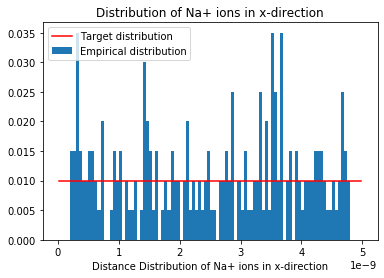

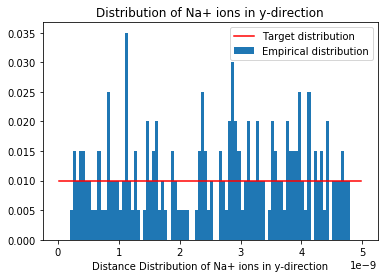

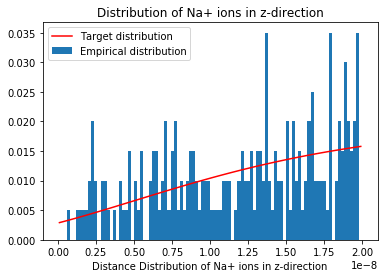

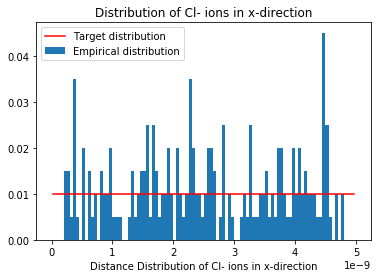

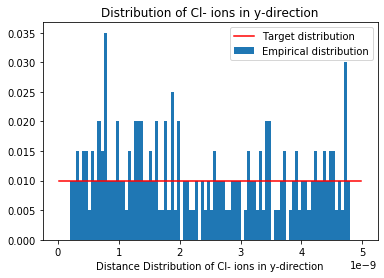

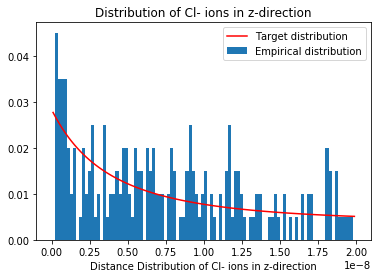

In [23]:
nbins = 101
for ion,sample,d in zip(species,steric_samples,distributions):
    histx, histy, histz = get_histogram(sample, box=box3, n_bins=nbins)
    plot_dist(histx, 'Distribution of {:s} ions in x-direction'.format(ion), 
              reference_distribution=lambda x: np.ones(x.shape)*1/box3[0])
    plot_dist(histy, 'Distribution of {:s} ions in y-direction'.format(ion), 
              reference_distribution=lambda x: np.ones(x.shape)*1/box3[1])
    plot_dist(histz, 'Distribution of {:s} ions in z-direction'.format(ion), 
              reference_distribution=d)

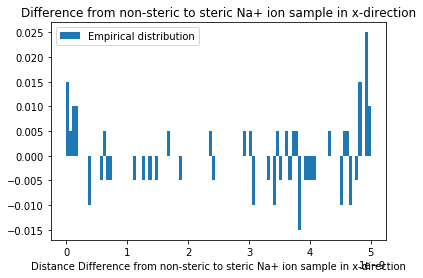

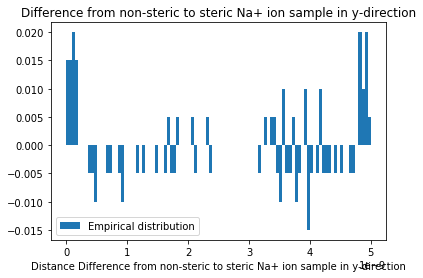

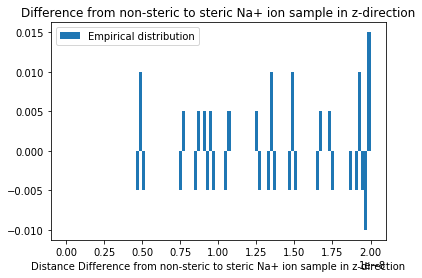

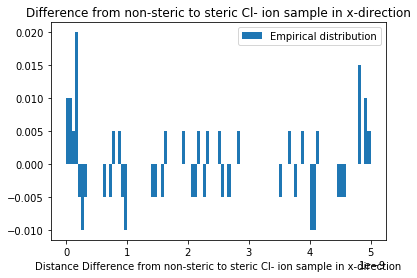

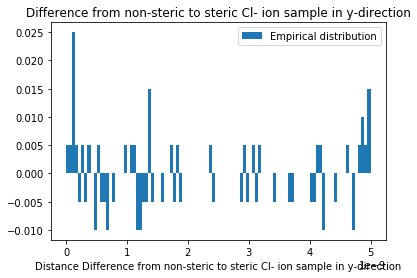

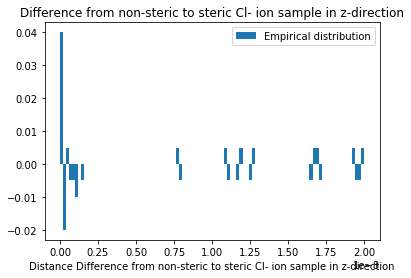

In [24]:
# Distribution of corrections
for ion,sample,steric_sample,d in zip(species,samples,steric_samples,distributions):
    hists = get_histogram(sample, box=box3, n_bins=nbins)    
    steric_hists = get_histogram(steric_sample, box=box3, n_bins=nbins)    
    # first entry is counts, second entry is bins
    diff_hists = [ (h[0] - hs[0], h[1]) for h,hs in zip(hists,steric_hists) ]
    for ax, h in zip( ['x','y','z'], diff_hists ):
        plot_dist(h, 'Difference from non-steric to steric {:s} ion sample in {:s}-direction'.format(ion, ax))

## Step 5: Write to file
We utilize ASE to export it to some standard format, i.e. LAMMPS data file.
ASE speaks Ångström per default, thus we convert SI units:

In [18]:
symbols = ['Na','Cl']

In [19]:
system = ase.Atoms(
    cell=np.diag(box3/sc.angstrom),
    pbc=[True,True,False]) 
for symbol, sample, charge in zip(symbols,samples,z):
    system += ase.Atoms(
        symbols=symbol*sample_size,
        charges=[charge]*sample_size,
        positions=sample/sc.angstrom)
system

Atoms(symbols='Cl200Na200', pbc=[True, True, False], cell=[50.0, 50.0, 200.0], initial_charges=...)

In [20]:
ase.io.write('NaCl_200_0.05V_5x5x20nm_at_interface_pb_distributed.lammps',system,format='lammps-data',units="real",atom_style='full')

In [29]:
steric_system = ase.Atoms(
    cell=np.diag(box3/sc.angstrom),
    pbc=[True,True,False]) 
for symbol, sample, charge in zip(symbols,steric_samples,z):
    steric_system += ase.Atoms(
        symbols=symbol*sample_size,
        charges=[charge]*sample_size,
        positions=sample/sc.angstrom)
steric_system

Atoms(symbols='Cl200Na200', pbc=[True, True, False], cell=[50.0, 50.0, 200.0], initial_charges=...)

In [30]:
ase.io.write('NaCl_200_0.05V_5x5x20nm_at_interface_pb_distributed_steric_correction_2Ang.lammps',steric_system,format='lammps-data',units="real",atom_style='full')

Displacement visualization between non-steric and steric sample with Ovito:

![Steric correction on 200 NaCl](steric_correction_on_200_NaCl_300px.png)

## Other performance tests

### Comparing target function implementations

In [31]:
# prepare coordinates and get system dimensions
xstacked = np.vstack(samples)

n   = xstacked.shape[0]
dim = xstacked.shape[1]

# normalize volume and coordinates
V = np.product(box6[1]-box6[0])
L = np.power(V,(1./dim))

x0 = xstacked / L

funcs = [
        brute_force_target_function,
        numpy_only_target_function,
        scipy_distance_based_target_function ]
func_names = ['brute','numpy','scipy']

# test for different scalings of coordinate set:
stats = []
K = np.exp(np.log(10)*np.arange(-3,3))
for k in K:
    lambdas = [ (lambda x0=xstacked,k=k,f=f: f(x0*k)) for f in funcs ]
    vals    = [ f() for f in lambdas ]
    times   = [ timeit.timeit(f,number=1) for f in lambdas ]
    diffs = scipy.spatial.distance.pdist(np.atleast_2d(vals).T,metric='euclidean')
    stats.append((k,*vals,*diffs,*times))

func_name_tuples = list(itertools.combinations(func_names,2))
diff_names = [ 'd_{:s}_{:s}'.format(f1,f2) for (f1,f2) in func_name_tuples ]
perf_names = [ 't_{:s}'.format(f) for f in func_names ]
fields =  ['k',*func_names,*diff_names,*perf_names]
dtypes = [ (field, '>f4') for field in fields ]
labeled_stats = np.array(stats,dtype=dtypes) 
stats_df = pd.DataFrame(labeled_stats)
print(stats_df.to_string(float_format='%8.6g'))

         k      brute      numpy      scipy  d_brute_numpy  d_brute_scipy  d_numpy_scipy   t_brute    t_numpy    t_scipy
0    0.001 1.2768e+06 1.2768e+06 1.2768e+06              0              0              0 0.0283376 0.00312492 0.00232604
1     0.01 1.2768e+06 1.2768e+06 1.2768e+06              0              0              0 0.0289534 0.00310434 0.00211156
2      0.1 1.2768e+06 1.2768e+06 1.2768e+06              0              0              0 0.0303592 0.00255587 0.00247849
3        1 1.2768e+06 1.2768e+06 1.2768e+06              0              0              0 0.0298618 0.00788925 0.00215799
4       10 1.2768e+06 1.2768e+06 1.2768e+06    4.42378e-09    4.42378e-09              0 0.0290546 0.00324231 0.00207012
5      100 1.2768e+06 1.2768e+06 1.2768e+06              0    4.65661e-10    4.65661e-10 0.0298927  0.0030192 0.00161168


Scipy-based target function fastest.

### Comparing closest pair implementations
See https://www.researchgate.net/publication/266617010_NumPy_SciPy_Recipes_for_Data_Science_Squared_Euclidean_Distance_Matrices

In [32]:
# test minimum distance function implementations on random samples

N = 1000
dim = 3

funcs = [
        brute_force_closest_pair,
        scipy_distance_based_closest_pair,
        planar_closest_pair ]
func_names = ['brute','scipy','planar']
stats = []

for k in range(5):
    x = np.random.rand(N,dim)
    lambdas = [ (lambda x=x,f=f: f(x)) for f in funcs ]
    rets    = [ f() for f in lambdas ]
    vals    = [ v[0] for v in rets ]
    coords  = [ c for v in rets for p in v[1] for c in p ]
    times   = [ timeit.timeit(f,number=1) for f in lambdas ]
    diffs   = scipy.spatial.distance.pdist(
        np.atleast_2d(vals).T,metric='euclidean')
    stats.append((*vals,*diffs,*times,*coords))

func_name_tuples = list(itertools.combinations(func_names,2))
diff_names =  [ 'd_{:s}_{:s}'.format(f1,f2) for (f1,f2) in func_name_tuples ]
perf_names =  [ 't_{:s}'.format(f) for f in func_names ]
coord_names = [ 
    'p{:d}{:s}_{:s}'.format(i,a,f) for f in func_names for i in (1,2) for a in ('x','y','z') ]
float_fields = [*func_names,*diff_names,*perf_names,*coord_names]
dtypes = [ (field, 'f4') for field in float_fields ]
labeled_stats = np.array(stats,dtype=dtypes)
stats_df = pd.DataFrame(labeled_stats)
print(stats_df.T.to_string(float_format='%8.6g'))

                         0           1           2           3           4
brute          8.23034e-05 6.24342e-05 7.73916e-05 0.000105018 6.21209e-06
scipy          8.23034e-05 6.24342e-05 7.73916e-05 0.000105018 6.21209e-06
planar         8.23034e-05 6.24342e-05 7.73916e-05 0.000105018 6.21209e-06
d_brute_scipy            0           0           0           0           0
d_brute_planar           0           0           0           0           0
d_scipy_planar           0           0           0           0           0
t_brute            2.60189     2.55688     2.56082     2.57091     2.56671
t_scipy         0.00479178  0.00462854  0.00457587  0.00457449  0.00491771
t_planar          0.268021    0.255359    0.263146    0.261899    0.249786
p1x_brute         0.718887    0.303597    0.984552    0.527871    0.825703
p1y_brute         0.459294     0.42578    0.844301    0.941305    0.795724
p1z_brute          0.17789    0.760662     0.97241    0.321066    0.684067
p2x_brute         0.71792

Scipy-based implementation fastest.

In [26]:
print('{}'.format(system.symbols))

Na200Cl200


In [28]:
system.cell.array

array([[ 50.,   0.,   0.],
       [  0.,  50.,   0.],
       [  0.,   0., 200.]])

In [33]:
np.array(system.get_cell_lengths_and_angles())

array([ 50.,  50., 200.,  90.,  90.,  90.])